In [1]:
import numpy as np

save_path = '../CSF/Notebooks/'

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltypes,clusters_final = np.unique(celllabels,return_inverse=True)

In [4]:

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
%matplotlib inline


In [2]:
def SignificanceDotPlot(fold_change, pvalue,names,colors,title,legend=False, ylim=5.5):
    df = pd.DataFrame([fold_change, pvalue,names,colors[:len(names)]],index=['fold_change','pvalue','names','colors']).T
    df = df.sort_values('fold_change',ascending=True)
    rank = np.argsort(np.argsort(-fold_change))
    for index, row in df.iterrows():
        if row['pvalue']==0: row['pvalue']=1e-5
        plt.scatter(np.log10(row['fold_change']), -np.log10(row['pvalue']),edgecolors='gray',
                   color=row['colors'],
                  label = row['names'],s=200)
        if legend==True:
            plt.legend(bbox_to_anchor=(1.1, 0.5),loc='center left', borderaxespad=0, fontsize=5)
        if (-np.log10(row['pvalue'])>1):
            plt.text(np.log10(row['fold_change'])-0.2, -np.log10(row['pvalue'])+0.2, row['names'], color=row['colors'],fontsize=20)       
        if (np.log10(row['pvalue'])>1):
            plt.text(np.log10(row['fold_change'])-0.2, -np.log10(row['pvalue'])+0.2, row['names'], color=row['colors'],fontsize=20)      
    plt.ylim(-0.1,ylim)
    plt.axhline(y=1, color='b', linestyle='--')
    plt.axvline(x=0)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axhline(y=1.3, color='r', linestyle='--')
    plt.title(title,fontsize=30)


In [3]:
tissue=np.concatenate([np.repeat('CSF',8),np.repeat('PBMC',10)])
states=np.asarray(['MS','MS','MS','MS','control','control','control','control',
                   'MS','MS','MS','MS','MS','control','control','control','control','control'])


isMS = np.load(save_path+'meta/isMS.npy')
isCSF = np.load(save_path+'meta/isCSF.npy')
batchid = np.load(save_path+'meta/batchid.npy')

In [8]:
clusters_final

array([ 6,  3,  3, ..., 12,  5, 12])

In [6]:
grouped_counts = []
for i in np.unique(clusters_final):
    count = np.asarray([
        np.sum((isMS*isCSF)[clusters_final==i]),
        np.sum(((isMS==False)*isCSF)[clusters_final==i]),
        np.sum((isMS*(isCSF==False))[clusters_final==i]),
        np.sum(((isMS==False)*(isCSF==False))[clusters_final==i]),
    ])
    grouped_counts.append(count)
    
grouped_counts = np.asarray(grouped_counts)
np.savetxt(save_path + 'count_test/final_louvain.grouped_count.txt',grouped_counts)

In [7]:
celltype_counts = []
for i in np.unique(clusters_final):
    count = np.asarray([np.sum((clusters_final==i)*(batchid==j))
        for j in np.unique(batchid)
    ])
    celltype_counts.append(count)
    
celltype_counts = np.asarray(celltype_counts)
np.savetxt(save_path + 'count_test/final_louvain.count.txt',celltype_counts)

In [8]:
total = np.sum(celltype_counts,0)

In [9]:
from scipy.stats import ttest_ind

def Ttest(X,N,C):
    p = np.asarray([x/n for x,n in zip(X,N)])
    pvalue =  ttest_ind(p[C==True],p[C==False])[1]
    foldchange = np.sum((X[C==True]+1)/N[C==True]) / np.sum((X[C==False]+1)/N[C==False])
    lfc = np.log10(foldchange) 
    return [foldchange,pvalue]


In [10]:
CSFp = []
for i,k in enumerate(np.unique(clusters_final)):
    CSFp.append(Ttest(celltype_counts[i,:],
                      total,
                      tissue=='CSF'))

CSFp = np.asarray([x for x in CSFp])

CSFp_con = []
for i,k in enumerate(np.unique(clusters_final)):
    CSFp_con.append(Ttest(celltype_counts[i,states=='control'],
                      total[states=='control'],
                      tissue[states=='control']=='CSF'))

CSFp_con = np.asarray([x for x in CSFp_con])

MSp = []
for i,k in enumerate(np.unique(clusters_final)):
        MSp.append(Ttest(celltype_counts[i,:],
                         total,
                         states=='MS'))

MSp = np.asarray([x for x in MSp])

CSFMSp = []
for i,k in enumerate(np.unique(clusters_final)):
    CSFMSp.append(Ttest(celltype_counts[i,tissue=='CSF'],
                        total[tissue=='CSF'],
                        states[tissue=='CSF']=='MS'))

CSFMSp = np.asarray([x for x in CSFMSp])
   

PBMCMSp = []
for i,k in enumerate(np.unique(clusters_final)):
    PBMCMSp.append(Ttest(celltype_counts[i,tissue!='CSF'],
                         total[tissue!='CSF'],
                         states[tissue!='CSF']=='MS'))
    
PBMCMSp = np.asarray([x for x in PBMCMSp])


In [11]:
filt = np.repeat(True,len(celltypes))
for i,x in enumerate(celltypes):
    if (x=='B cell doublets') or (x=='Mono Doublet') or (x=='RBC') or (x=='contamination1') or (x=='doublet'):
        filt[i]=False 

MSp = MSp[filt,:]
CSFp = CSFp[filt,:]
CSFMSp = CSFMSp[filt,:]
PBMCMSp = PBMCMSp[filt,:]
CSFp_con = CSFp_con[filt,:]
celltypes = celltypes[filt]
celltype_counts = celltype_counts[filt,:]

In [12]:
celltype_counts[celltypes=='ncMono'][0][(tissue=='CSF')*(states=='MS')]

array([ 53,  11,  22, 105])

In [13]:
celltype_counts[celltypes=='ncMono'][0][(tissue=='CSF')*(states=='control')]

array([412, 144, 464,   1])

In [14]:
celltype_counts[celltypes=='ncMono'][0][(tissue=='PBMC')*(states=='control')]

array([18, 39,  6,  8,  7])

In [15]:
celltype_counts[celltypes=='ncMono'][0][(tissue=='PBMC')*(states=='MS')]

array([24, 14, 17,  3, 66])

In [16]:
import pandas as pd

In [14]:
colors = ['#ff0000', '#e30000', '#c70000', '#732b20', '#c7601c', '#ff9924', '#735210', '#ab9f00', '#eeff00', '#2b5724', '#1cc749', '#1cc7a5', '#5fc9e3', '#24b6ff', '#205773', '#3061ab', '#001f73', '#6b7fff', '#601cc7', '#8f3c89', '#ff24d3', '#570023']
colors = np.asarray(colors)
colors = colors[filt==True]

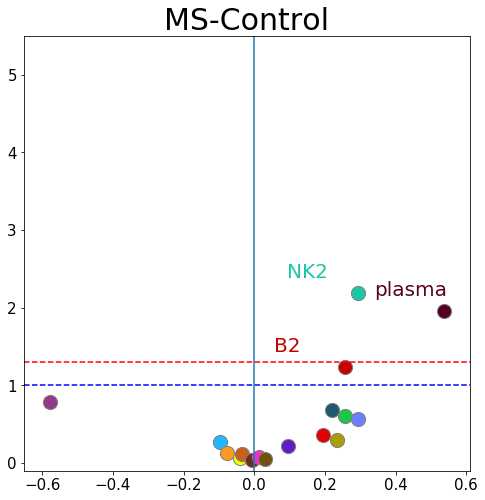

In [18]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(MSp[:,0],MSp[:,1],celltypes,colors,'MS-Control')
plt.savefig(save_path + 'figures/Figure1/Ttest_MSControl.pdf')

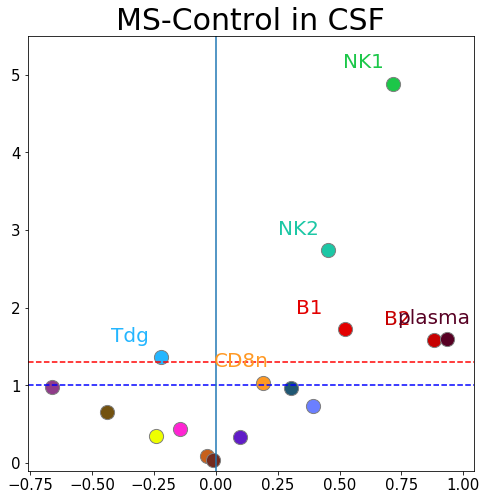

In [19]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFMSp[:,0],CSFMSp[:,1],celltypes,colors,'MS-Control in CSF')
plt.savefig(save_path + 'figures/Figure1/Ttest_MSControl_CSF.pdf')

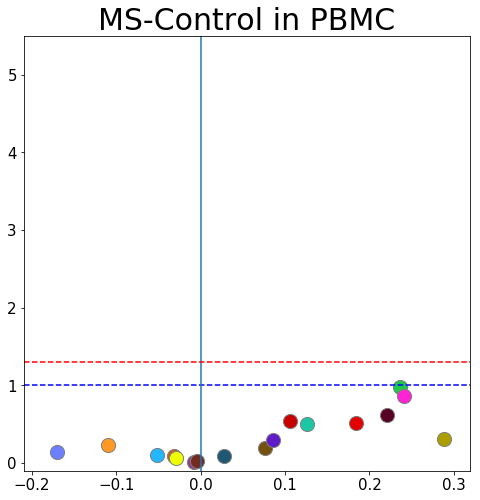

In [20]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(PBMCMSp[:,0],PBMCMSp[:,1],celltypes,colors,'MS-Control in PBMC')
plt.savefig(save_path + 'figures/Figure1/Ttest_MSControl_PBMC.pdf')

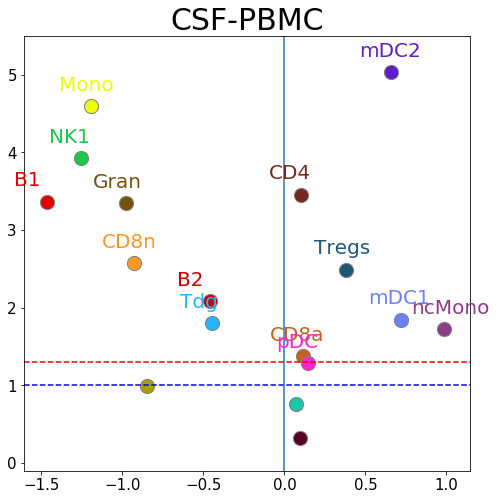

In [21]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp[:,0],CSFp[:,1],celltypes,colors,'CSF-PBMC')
plt.savefig(save_path + 'figures/Figure1/Ttest_CSFPBMC.pdf')

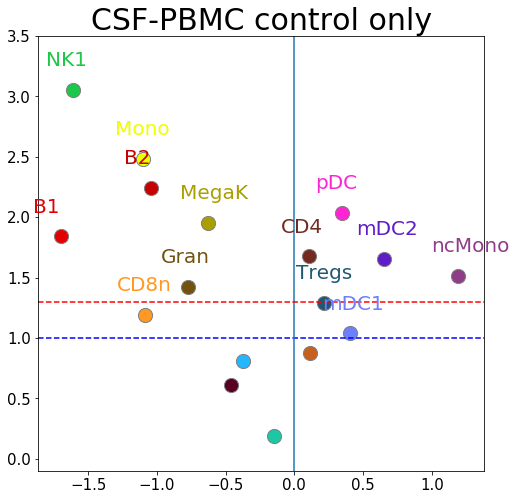

In [17]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp_con[:,0],CSFp_con[:,1],celltypes,colors,'CSF-PBMC control only',ylim=3.5)
plt.savefig(save_path + 'figures/Figure1/Ttest_CSFPBMC_control.pdf')

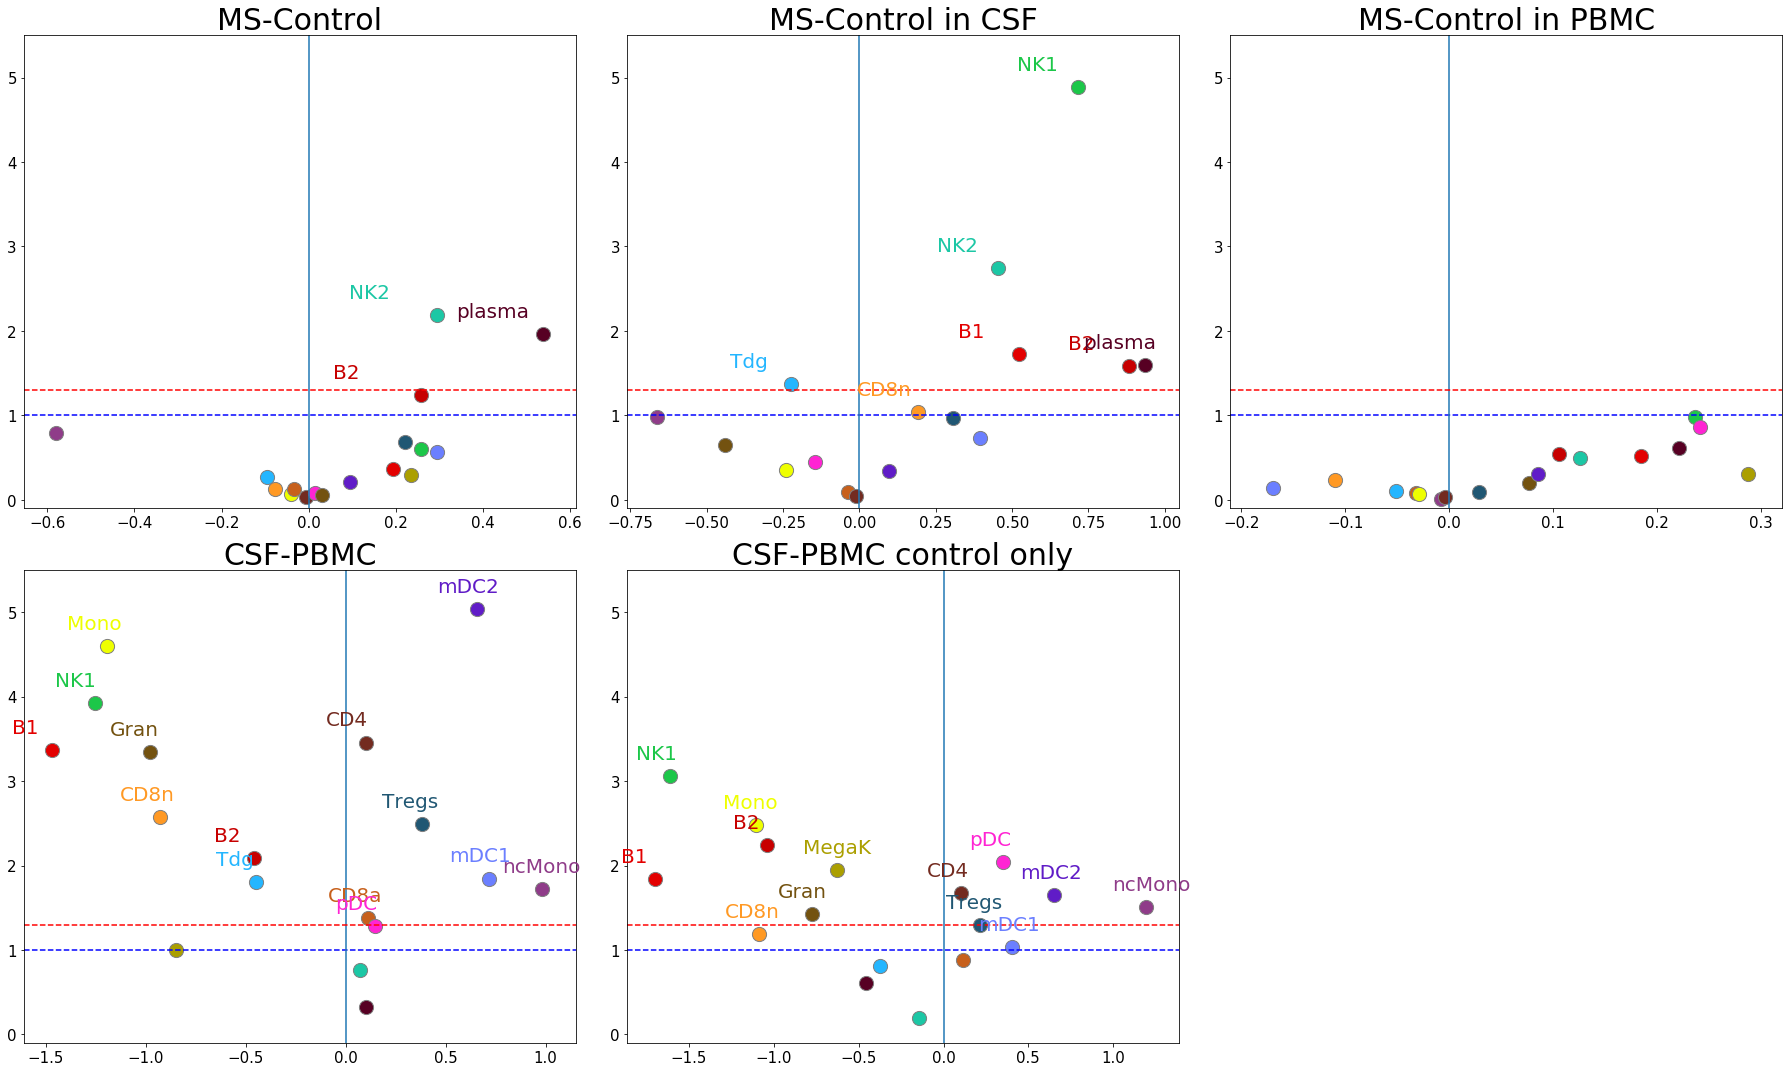

In [23]:
plt.figure(figsize=(25,15))
plt.subplot(2, 3, 1)
SignificanceDotPlot(MSp[:,0],MSp[:,1],celltypes,colors,'MS-Control')
plt.subplot(2, 3, 2)
SignificanceDotPlot(CSFMSp[:,0],CSFMSp[:,1],celltypes,colors,'MS-Control in CSF')
plt.subplot(2, 3, 3)
SignificanceDotPlot(PBMCMSp[:,0],PBMCMSp[:,1],celltypes,colors,'MS-Control in PBMC')
plt.subplot(2, 3, 4)
SignificanceDotPlot(CSFp[:,0],CSFp[:,1],celltypes,colors,'CSF-PBMC')
plt.subplot(2, 3, 5)
SignificanceDotPlot(CSFp_con[:,0],CSFp_con[:,1],celltypes,colors,'CSF-PBMC control only')
plt.tight_layout()
plt.savefig(save_path+'figures/Ttest.DiffProp.pdf')

In [23]:
CSFp = np.genfromtxt(save_path+'count_test/final_louvain.betabinomreg.CSF.csv',delimiter=',')
CSFp_con = np.genfromtxt(save_path+'count_test/final_louvain.betabinomreg.CSF_control.csv',delimiter=',')
MSp = np.genfromtxt(save_path+'count_test/final_louvain.betabinomreg.MS.csv',delimiter=',')
CSFMSp = np.genfromtxt(save_path+'count_test/final_louvain.betabinomreg.CSFMS.csv',delimiter=',')
PBMCMSp = np.genfromtxt(save_path+'count_test/final_louvain.betabinomreg.PBMCMS.csv',delimiter=',')

In [24]:
MSp = MSp[filt,:]
CSFp = CSFp[filt,:]
CSFMSp = CSFMSp[filt,:]
PBMCMSp = PBMCMSp[filt,:]
CSFp_con = CSFp_con[filt,:]

In [25]:
np.max(CSFp[:,1])

12.7151116639043

/data/yosef2/users/chenling/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


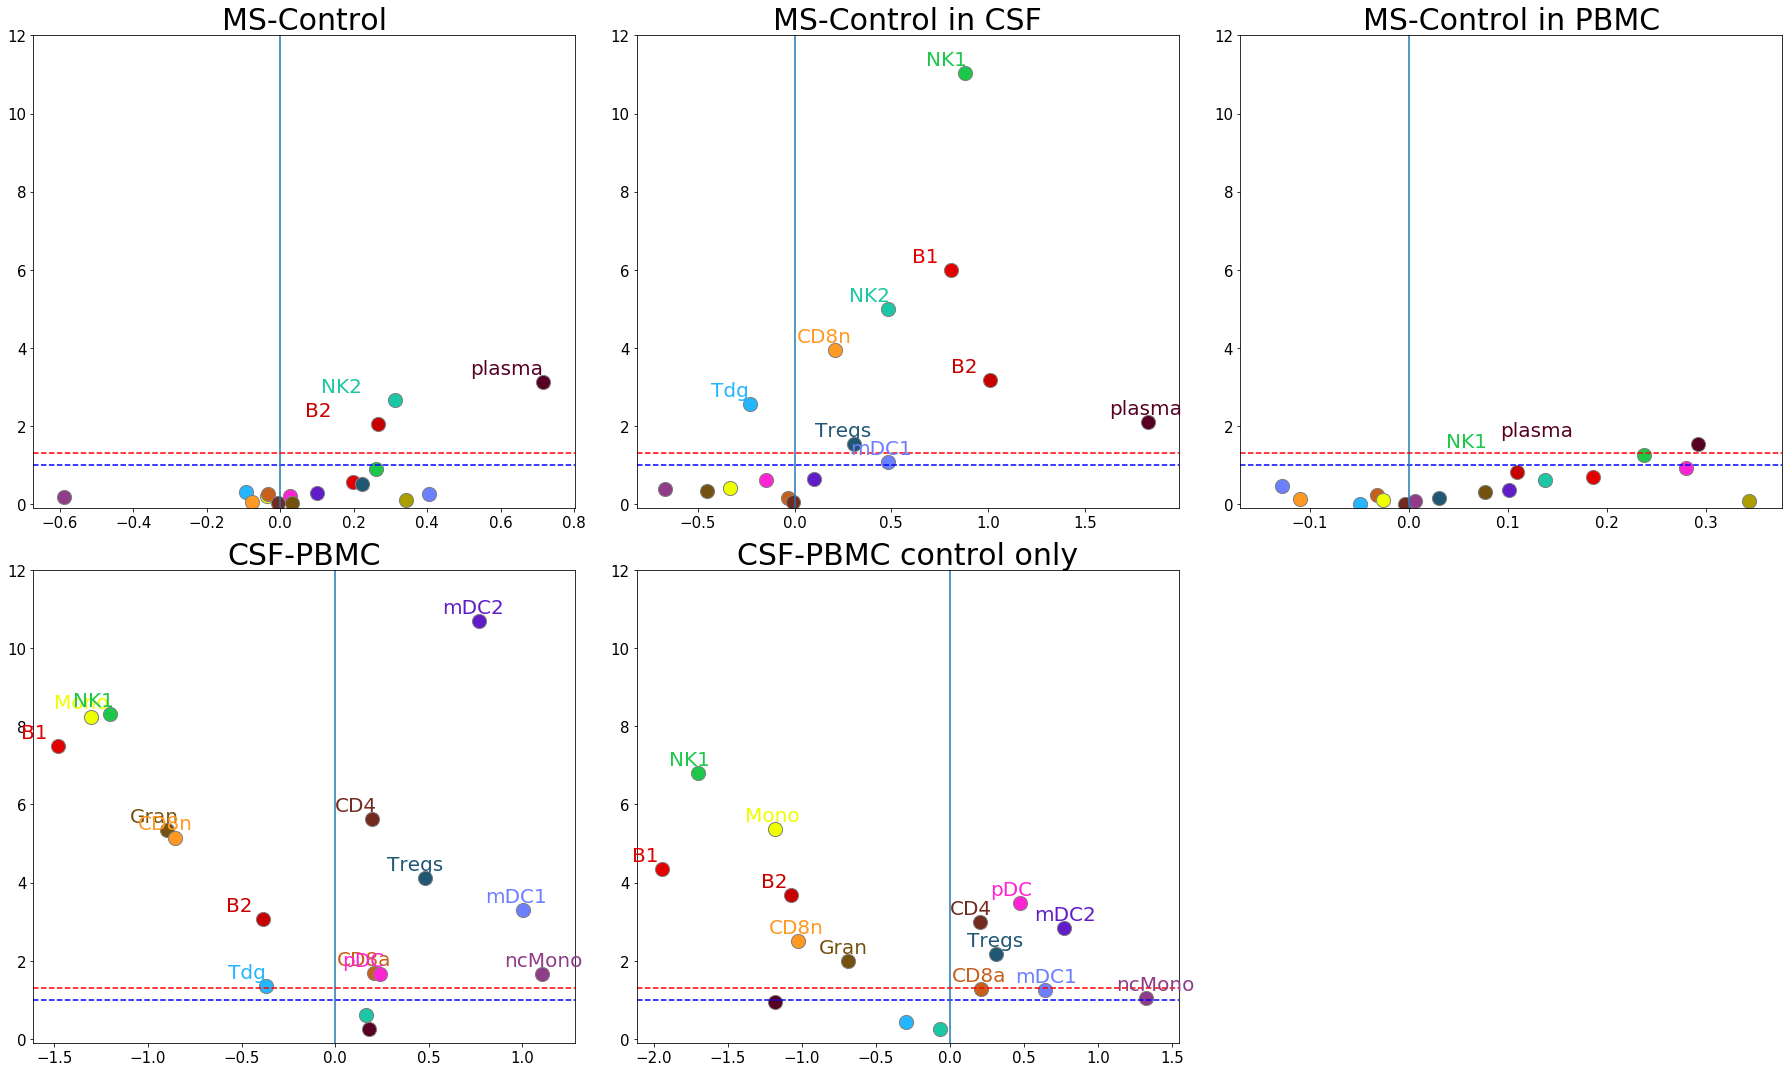

In [26]:
plt.figure(figsize=(25,15))
plt.subplot(2, 3, 1)
SignificanceDotPlot(MSp[:,1],MSp[:,0],celltypes,colors,'MS-Control',ylim=12)
plt.subplot(2, 3, 2)
SignificanceDotPlot(CSFMSp[:,1],CSFMSp[:,0],celltypes,colors,'MS-Control in CSF',ylim=12)
plt.subplot(2, 3, 3)
SignificanceDotPlot(PBMCMSp[:,1],PBMCMSp[:,0],celltypes,colors,'MS-Control in PBMC',ylim=12)
plt.subplot(2, 3, 4)
SignificanceDotPlot(CSFp[:,1],CSFp[:,0],celltypes,colors,'CSF-PBMC',ylim=12)
plt.subplot(2, 3, 5)
SignificanceDotPlot(CSFp_con[:,1],CSFp_con[:,0],celltypes,colors,'CSF-PBMC control only',ylim=12)
plt.tight_layout()
plt.savefig(save_path+'figures/BetaBinomial.DiffProp.pdf')

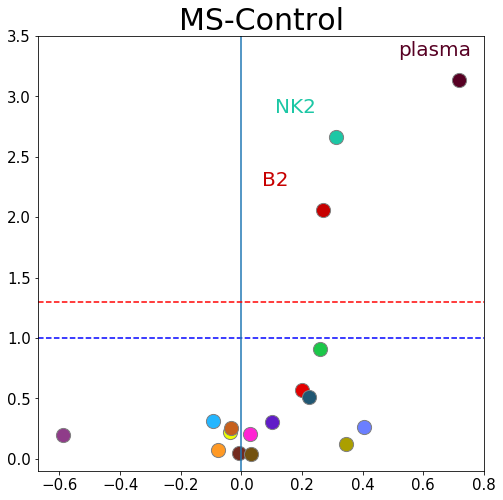

In [29]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(MSp[:,1],MSp[:,0],celltypes,colors,'MS-Control',ylim=3.5)
plt.savefig(save_path + 'figures/Figure1/BetaBinomial_MSControl.pdf')

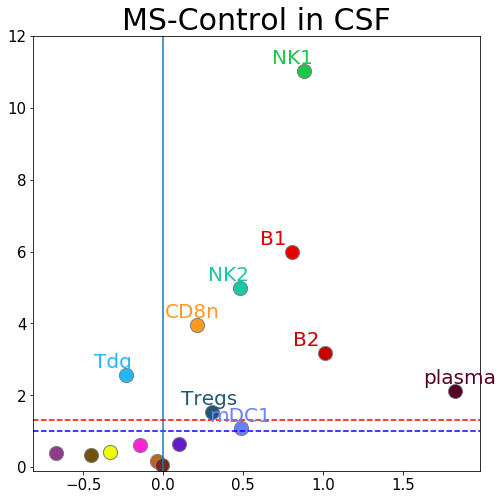

In [42]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFMSp[:,1],CSFMSp[:,0],celltypes,colors,'MS-Control in CSF',ylim=12)
plt.savefig(save_path + 'figures/Figure1/BetaBinomial_MSControl_CSF.pdf')

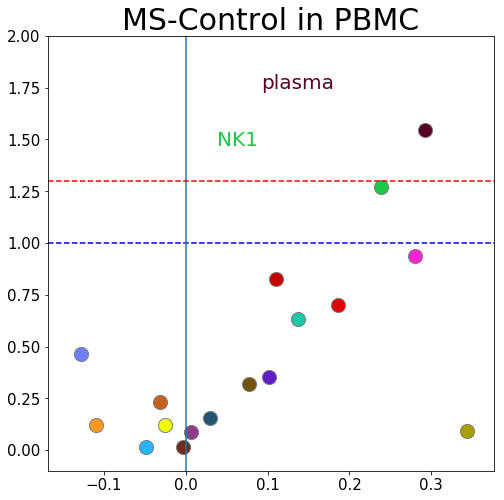

In [27]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(PBMCMSp[:,1],PBMCMSp[:,0],celltypes,colors,'MS-Control in PBMC',ylim=2)
plt.savefig(save_path + 'figures/Figure1/BetaBinomial_MSControl_PBMC.pdf')

/data/yosef2/users/chenling/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


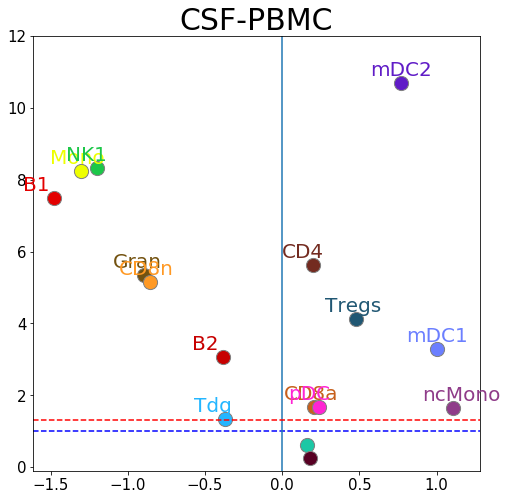

In [44]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp[:,1],CSFp[:,0],celltypes,colors,'CSF-PBMC',ylim=12)
plt.savefig(save_path + 'figures/Figure1/BetaBinomial_CSFPBMC.pdf')

/data/yosef2/users/chenling/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


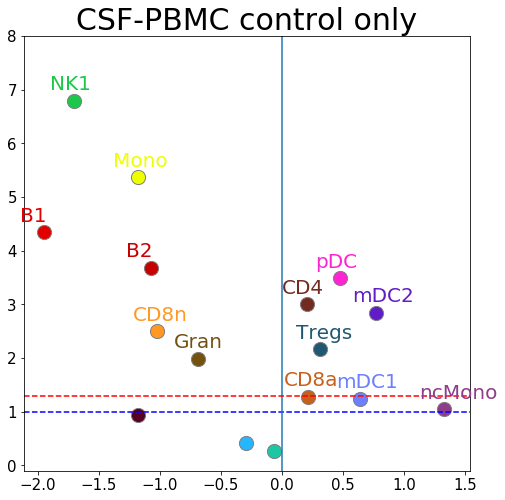

In [26]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp_con[:,1],CSFp_con[:,0],celltypes,colors,'CSF-PBMC control only',ylim=8)
plt.savefig(save_path + 'figures/Figure1/BetaBinomial_CSFPBMC_control.pdf')

In [32]:
def Heatmap(count,total,rankby,rownames,colnames,title,filename,width=9,height=8, save_path = save_path+'figures/'):
    freq=[]
    nfreq = []
    for i in range(len(count[0,:])):
        f = (count[:,i]+1)/total
        freq.append(f)
        nf = np.mean(f)
        nfreq.append(np.log10(f/nf))

    freq = np.asarray(freq)
    nfreq = np.asarray(nfreq)
    ranked = np.argsort(rankby)
    fig, ax = plt.subplots(figsize=(width,height))
    # We want to show all ticks...
    plt.imshow(nfreq[ranked,:],aspect='auto',cmap='bwr')
    plt.colorbar()
    ax.set_xticks(np.arange(len(rownames)))
    ax.set_yticks(np.arange(len(colnames)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(rownames,fontsize=20)
    ax.set_yticklabels(colnames[ranked],fontsize=20)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    print(count.shape,freq.shape,nfreq.shape,ranked.shape)
    for i in range(len(colnames)):
        for j in range(len(rownames)):
            text = ax.text(j, i, "{:.0f}".format(count.T[ranked,:][i,j]),
                           ha="center", va="center",fontsize=15)
    ax.set_title(title,fontsize=30)
    fig.tight_layout()
    plt.savefig(save_path + filename, transparency=True)



In [33]:
samplenames = [x+'_'+states[i] for i,x in enumerate(tissue)]
samplenames = np.asarray(samplenames)

(18, 17) (17, 18) (17, 18) (17,)


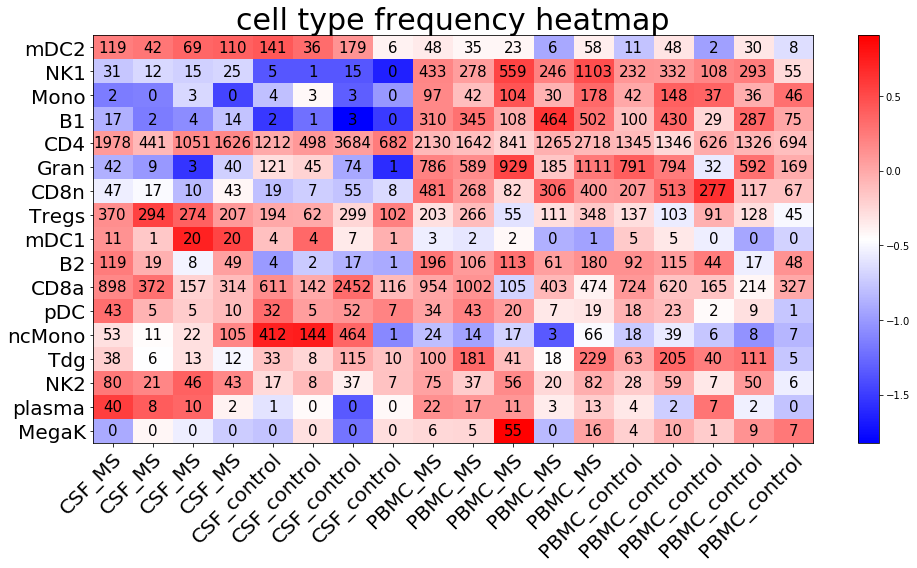

In [34]:
Heatmap(celltype_counts.T, total,CSFp[:,0], samplenames,celltypes,'cell type frequency heatmap','SupFigure3/freq.heatmap.pdf',width=14)


(8, 17) (17, 8) (17, 8) (17,)


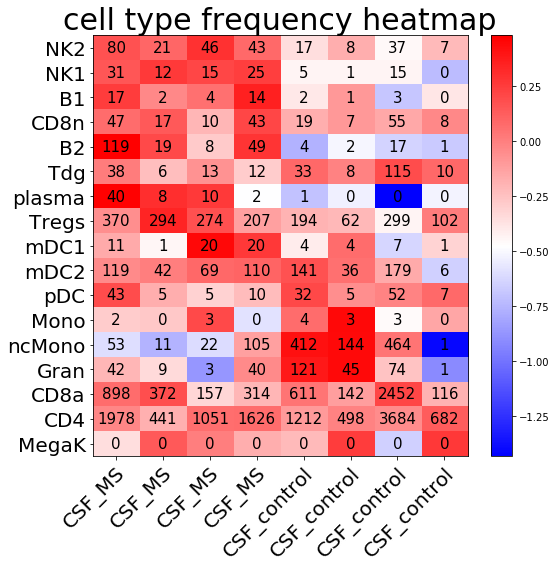

In [35]:
Heatmap(celltype_counts.T[tissue=='CSF',:], total[tissue=='CSF'],CSFMSp[:,0], samplenames[tissue=='CSF'],
        celltypes,'cell type frequency heatmap','CSF.freq.heatmap.pdf',width=8)


(10, 17) (17, 10) (17, 10) (17,)


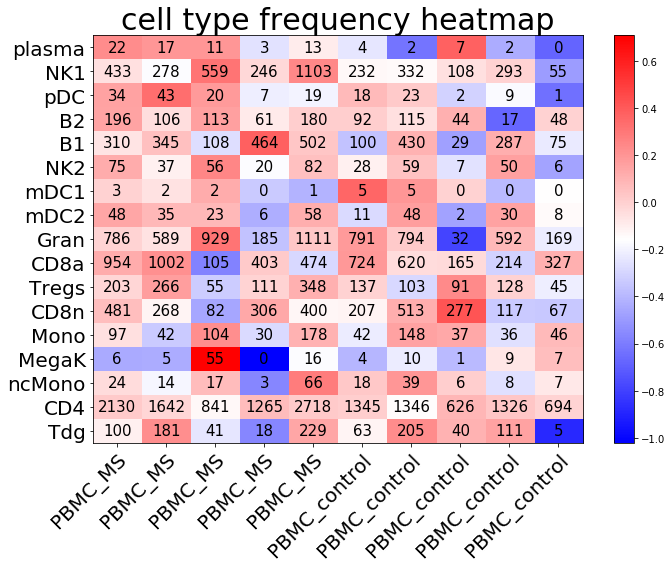

In [36]:
Heatmap(celltype_counts.T[tissue=='PBMC',:], total[tissue=='PBMC'],PBMCMSp[:,0], samplenames[tissue=='PBMC'],
        celltypes,'cell type frequency heatmap','PBMC.freq.heatmap.pdf',width=10)


In [37]:
grouped_count= np.asarray([np.sum(celltype_counts.T[samplenames==name,:],axis=0) for name in np.unique(samplenames)])

In [38]:
grouped_total= np.asarray([np.sum(total[samplenames==name]) for name in np.unique(samplenames)])

(4, 17) (17, 4) (17, 4) (17,)


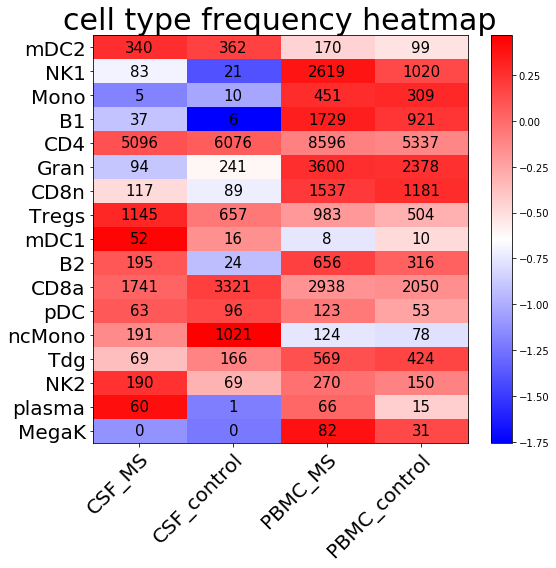

In [39]:
Heatmap(grouped_count, grouped_total,CSFp[:,0], np.unique(samplenames),
        celltypes,'cell type frequency heatmap','grouped.freq.heatmap.pdf',width=8)